In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

# Run this cell before the lab !
# It will download PascalVOC dataset (400Mo) and 
# pre-computed representations of images (450Mo)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

import tarfile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


URL_VOC = ("http://host.robots.ox.ac.uk/pascal/VOC/"
           "voc2007/VOCtrainval_06-Nov-2007.tar")
FILE_VOC = "VOCtrainval_06-Nov-2007.tar"
FOLDER_VOC = "VOCdevkit"

if not op.exists(FILE_VOC):
    print('Downloading from %s to %s...' % (URL_VOC, FILE_VOC))
    urlretrieve(URL_VOC, './' + FILE_VOC)

if not op.exists(FOLDER_VOC):
    print('Extracting %s...' % FILE_VOC)
    tar = tarfile.open(FILE_VOC)
    tar.extractall()
    tar.close()

URL_REPRESENTATIONS = ("https://github.com/m2dsupsdlclass/lectures-labs/"
                       "releases/download/0.2/voc_representations.h5")
FILE_REPRESENTATIONS = "voc_representations.h5"

if not op.exists(FILE_REPRESENTATIONS):
    print('Downloading from %s to %s...'
          % (URL_REPRESENTATIONS, FILE_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + FILE_REPRESENTATIONS)

Extracting VOCtrainval_06-Nov-2007.tar...


ReadError: file could not be opened successfully:
- method gz: ReadError('not a gzip file')
- method bz2: ReadError('not a bzip2 file')
- method xz: ReadError('not an lzma file')
- method tar: ReadError('invalid header')

# Classification and Localization model

The objective is to build and train a classification and localization network. This exercise will showcase the flexibility of Deep Learning with several, heterogenous outputs (bounding boxes and classes)

We will build the model in three consecutive steps:
- **Extract label annotations** from a standard Object Detection dataset, namely **Pascal VOC 2007**;
- Use a pre-trained image classification model (namely ResNet50) to **precompute convolutional representations** with shape `(7, 7, 2048)` for all the images in the object detection training set;
- **Design and train a baseline object detection model with two heads** to predict: 
  - class labels (5 possible classes)
  - bounding box coordinates of a single detected object in the image

Note that the simple baseline model presented in this notebook will only detect a single occurence of a class per image. More work would be required to detect all possible object occurences in the images. See the lecture slides for refernces to state of the art object detection models such as Faster RCNN and YOLO9000.


## Loading images and annotations

We will be using Pascal VOC 2007, a dataset widely used in detection and segmentation http://host.robots.ox.ac.uk/pascal/VOC/ To lower memory footprint and training time, we'll only use 5 classes: "dog", "cat", "bus", "car", "aeroplane". Here are the first steps:
- Load the annotations file from pascalVOC and parse it (xml file)
- Keep only the annotations we're interested in, and containing a single object
- Pre-compute ResNet conv5c from the corresponding images


In [2]:
from __future__ import division
import numpy as np
import xml.etree.ElementTree as etree
import os
import os.path as op

# Parse the xml annotation file and retrieve the path to each image,
# its size and annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [{obj.find("name").text:[int(obj.find("bndbox/xmin").text), 
                                     int(obj.find("bndbox/ymin").text), 
                                     int(obj.find("bndbox/xmax").text), 
                                     int(obj.find("bndbox/ymax").text)]} 
             for obj in objects]
    return {"size": size, "filename": fname, "objects": dicts}

In [3]:
# Filters annotations keeping only those we are interested in
# We only keep images in which there is a single item
annotations = []

filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

annotation_folder = "VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))

    new_objects = []
    for obj in annotation["objects"]:
        # keep only labels we're interested in
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    # Keep only if there's a single object in the image
    if len(new_objects) == 1:
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

FileNotFoundError: [Errno 2] No such file or directory: 'VOCdevkit/VOC2007/Annotations/'

In [4]:
print("Number of images with annotations:", len(annotations))

Number of images with annotations: 0


In [5]:
print("Contents of annotation[0]:\n", annotations[0])

IndexError: list index out of range

In [6]:
print("Correspondence between indices and labels:\n", idx2labels)

Correspondence between indices and labels:
 {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}


## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a `(7, 7, 2048)` dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.


**Exercise**: Load a headless pre-trained `ResNet50` model from Keras and all the layers after the `AveragePooling2D` layer (included):

In [7]:
# TODO

headless_conv = None

In [8]:
# %load solutions/load_pretrained.py

### Predicting on a batch of images

The `predict_batch` function is defined as follows:
- open each image, and resize them to `img_size`
- stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
- preprocess the batch and make a forward pass with the model

In [9]:
from skimage.io import imread
from skimage.transform import resize

from keras.applications.imagenet_utils import preprocess_input

def predict_batch(model, img_batch_path, img_size=None):
    img_list = []

    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = resize(img, img_size, mode='reflect', preserve_range=True)

        img = img.astype('float32')
        img_list.append(img)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    return model(preprocess_input(img_batch)).numpy()

/home/rth/src/dl-lectures-labs/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Let's test our model:

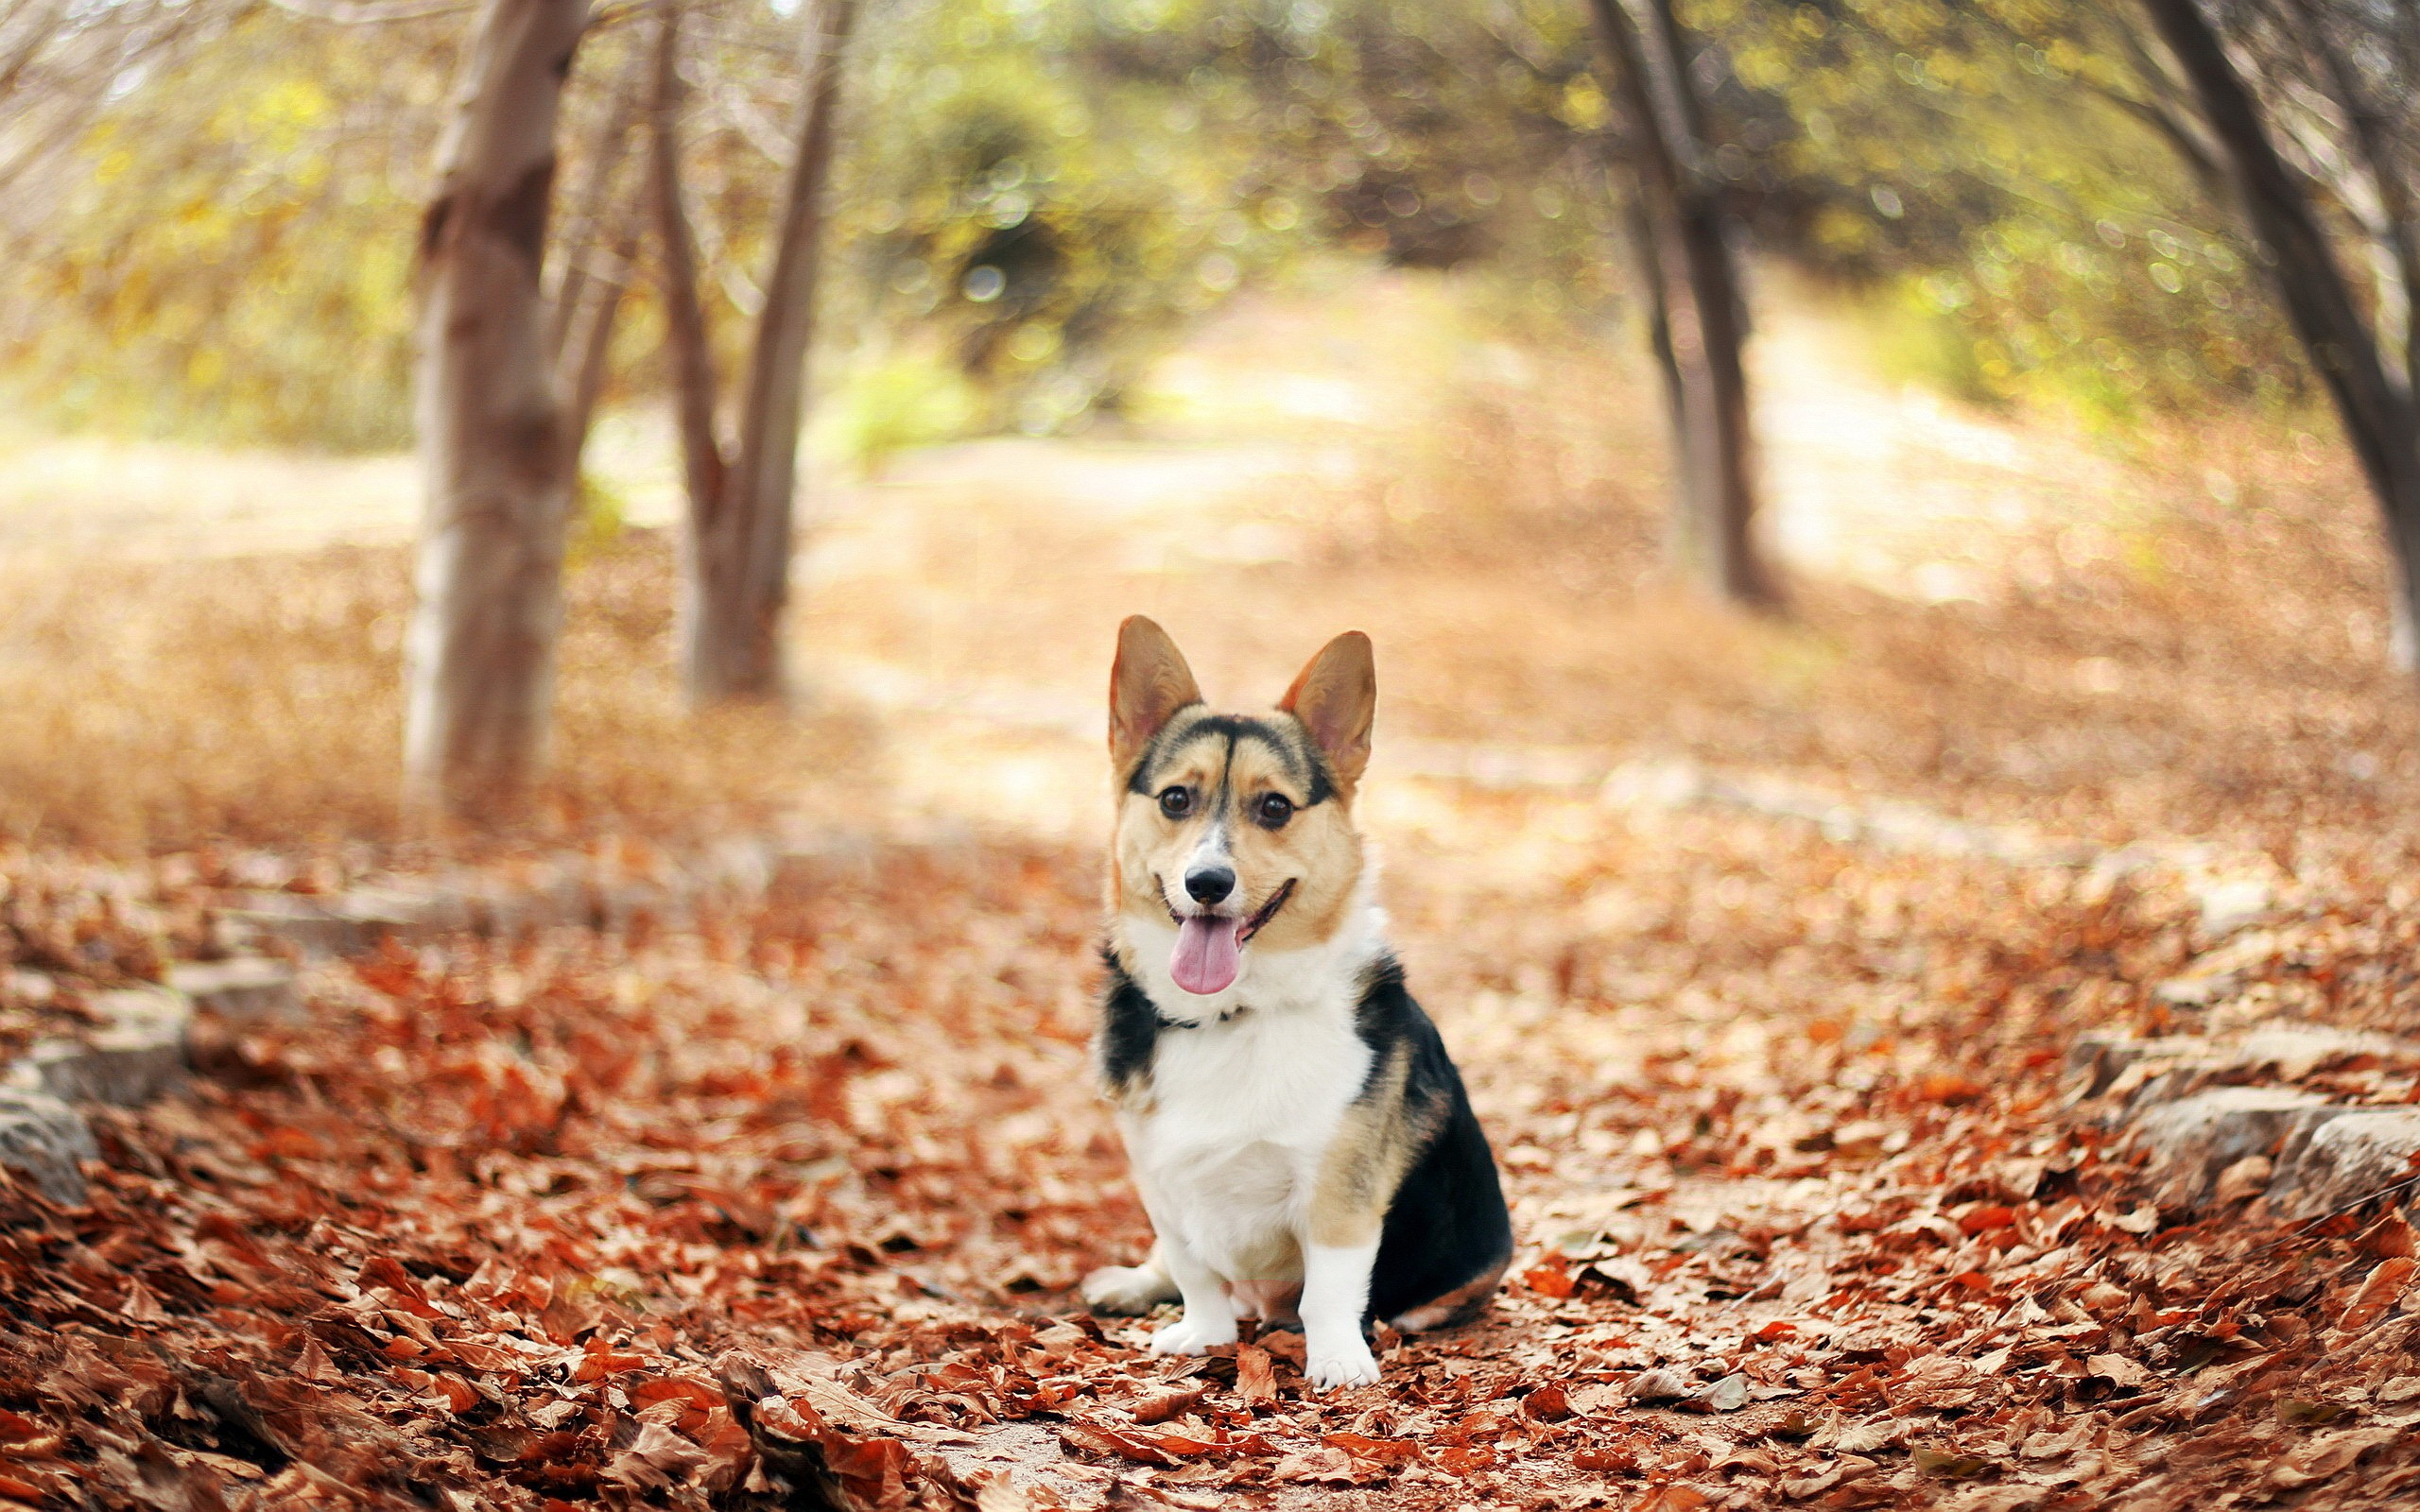

In [10]:
from IPython.display import Image
Image('dog.jpg', width=1000)

In [11]:
output = predict_batch(headless_conv, ["dog.jpg"], (1000, 224))
print("output shape", output.shape)

TypeError: 'NoneType' object is not callable

The output size is `(batch_size, 1000/32 = 32, 224/32 = 7, 2048)`

### Compute representations on all images in our annotations

Computing representations for all images may take some time (especially without a GPU), so it was pre-computed and save in `voc_representations.h5`

This was achieved through the `compute_representations.py` script, you're welcome to use it if needed.

Otherwise, load the pre-trained representations in h5 format using the following:

In [12]:
import h5py

with h5py.File('voc_representations.h5', 'r') as h5f:
    reprs = h5f['reprs'][:]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'voc_representations.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. 

We will build the `y_true` tensor that will be compared to the output of the model.

#### Boxes coordinates

- The image is resized to a fixed 224x224 to be fed to the usual ResNet50 input, the boxes coordinates of the annotations need to be resized accordingly.
- We have to convert the top-left and bottom-right coordinates `(x1, y1, x2, y2)` to center, height, width `(xc, yc, w, h)`

#### Classes labels

- The class labels are mapped to corresponding indexes

In [13]:
img_resize = 224
num_classes = len(labels2idx.keys())


def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation["class"]]
        cls[cls_idx] = 1.0
        
        coords = annotation["bbox"]
        size = annotation["size"]
        # resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1], 
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        
        # compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [14]:
classes, boxes = tensorize_ground_truth(annotations)

ValueError: need at least one array to concatenate

In [15]:
print("Classes and boxes shapes:", classes.shape, boxes.shape)

NameError: name 'classes' is not defined

In [16]:
print("First 2 classes labels:\n")
print(classes[0:2])

First 2 classes labels:



NameError: name 'classes' is not defined

In [17]:
idx2labels

{0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}

In [18]:
print("First 2 boxes coordinates:\n")
print(boxes[0:2])

First 2 boxes coordinates:



NameError: name 'boxes' is not defined

### Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidence) and boxes coordinates. It corresponds to reverting the previous process.


In [19]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2), 
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize), 
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize), 
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {"class": classname, "confidence": confidence, "bbox": fullsize_box}
    return output

**Sanity check**: interpret the classes and boxes tensors of some known annotations:

In [20]:
img_idx = 1

print("Original annotation:\n")
print(annotations[img_idx])

Original annotation:



IndexError: list index out of range

In [21]:
print("Interpreted output:\n")
print(interpret_output(classes[img_idx], boxes[img_idx],
                       img_size=annotations[img_idx]["size"]))

Interpreted output:



NameError: name 'classes' is not defined

### Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground truth box and predicted box. 
The following function computes the IoU:

In [22]:
def iou(boxA, boxB):
    # find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)

    # compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas - the interesection area
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [23]:
iou([47, 35, 147, 101], [1, 124, 496, 235])

0.0

In [24]:
iou([47, 35, 147, 101], [47, 35, 147, 101])

1.0

In [25]:
iou([47, 35, 147, 101], [49, 36, 145, 100])

0.9309090909090909

#### Sanity check

The IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation be close to 1.0:

In [26]:
for img_idx in range(10):
    original = annotations[img_idx]
    interpreted = interpret_output(classes[img_idx], boxes[img_idx],
                                   img_size=annotations[img_idx]["size"])

    print("IoU:", iou(original["bbox"], interpreted["bbox"]))

IndexError: list index out of range

#### Visual sanity check

Matplotlib makes it possible to draw rectangles on a 2D plane as follows:

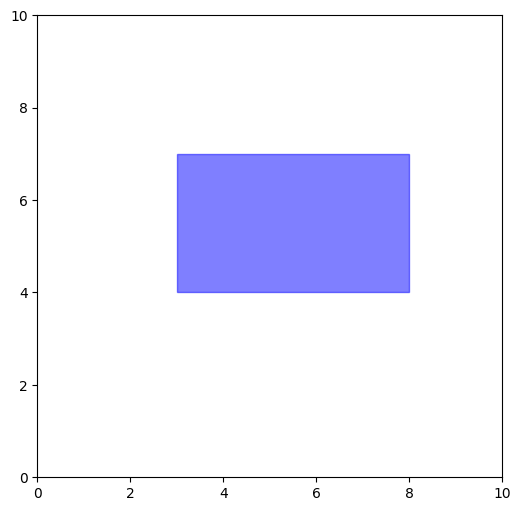

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
ax.add_patch(plt.Rectangle((3, 4), 5, 3, color='blue', alpha=0.5));

**Exercise**

Write a function that:

- takes 2 boxes as arguments,
- plots the boxes as 2 rectangles in a (10 x 10) plane,
- and displays the value of IoU of the 2 boxes in the plt title.

In [28]:
def plot_iou(boxA, boxB, img_size=(10, 10)):
    # TODO!
    pass


plot_iou([2, 2, 8, 8], [3, 3, 7, 9])
plot_iou([2, 2, 8, 8], [2, 2, 8, 9])
plot_iou([2, 2, 8, 8], [0, 1, 1, 5])
plot_iou([2, 2, 8, 8], [1, 1, 10, 3])

In [29]:
# %load solutions/plot_iou.py

### Classification and Localization model

A two headed model for single object classification and localization.

In [30]:
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.layers import Input, Conv2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model


def classif_and_loc_stupid_model(num_classes):
    """Stupid model that averages all the spatial information
    
    The goal of this model it to show that it's a very bad idea to
    destroy the spatial information with GlobalAveragePooling2D layer
    if our goal is to do object localization.
    """
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    head_boxes = Dense(4, name="head_boxes")(x)
    
    model = Model(model_input, outputs=[head_classes, head_boxes],
                  name="resnet_loc")
    model.compile(optimizer="adam", loss=[categorical_crossentropy, "mse"],
                  loss_weights=[1., 0.01]) 
    return model

In [31]:
stupid_model = classif_and_loc_stupid_model(num_classes)

Let's debug the model: select only a few examples and test the model before training with random weights:

In [32]:
num = 64
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print("Input batch shape:", inputs.shape)
print("Ground truth batch shapes:", out_cls.shape, out_boxes.shape)

NameError: name 'reprs' is not defined

Let's check that the classes are approximately balanced (except class 2 which is 'bus'):

In [33]:
out_cls.mean(axis=0)

NameError: name 'out_cls' is not defined

In [34]:
out = stupid_model(inputs)
print("model output shapes:", out[0].shape, out[1].shape)

NameError: name 'inputs' is not defined

Now check whether the loss decreases and eventually if we are able to overfit on these few examples for debugging purpose.

In [35]:
history = stupid_model.fit(inputs, [out_cls, out_boxes],
                           batch_size=10, epochs=10)

NameError: name 'inputs' is not defined

In [36]:
import matplotlib.pyplot as plt
plt.plot(np.log(history.history["head_boxes_loss"]), label="boxes_loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="classes_loss")
plt.plot(np.log(history.history["loss"]), label="loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

NameError: name 'history' is not defined

### Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
- display the image
- display on top annotations and ground truth bounding boxes and classes

The `display` function:
- takes a single index and computes the result of the model
- interpret the output of the model as a bounding box
- calls the `plot_annotations` function

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white',
              bbox={'facecolor': color, 'alpha': 0.7})


def plot_annotations(img_path, annotation=None, ground_truth=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    img = imread(img_path)
    ax.imshow(img)
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(ax, ground_truth["bbox"], text, "red")
    if annotation:
        conf = '{:0.2f} '.format(annotation['confidence'])
        text = conf + annotation["class"]
        patch(ax, annotation["bbox"], text, "blue")
    plt.axis('off')
    plt.show()


def display_prediction(model, index, ground_truth=True):
    res = model(reprs[index][np.newaxis,])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations("VOCdevkit/VOC2007/JPEGImages/" + annotations[index]["filename"], 
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set:

In [38]:
display_prediction(stupid_model, 13)

NameError: name 'reprs' is not defined

The class should be right but the localization has little chance to be correct.

The model has even more trouble on images that were not part of our tiny debugging training set:

In [39]:
display_prediction(stupid_model, 189)

NameError: name 'reprs' is not defined

### Computing Accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
- the argmax of `output_class` of the model is `class_true`
- the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually `0.5`)

The accuracy of a model is then number of positive / total_number

The following functions compute the class accuracy, iou average and global accuracy:

In [40]:
# Compute class accuracy, iou average and global accuracy
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [41]:
# Compute the previous function on the whole train / test set
def compute_acc(model, train=True):
    n_samples = len(annotations)
    if train:
        beg, end = 0, (9 * n_samples // 10)
        split_name = "train"
    else:
        beg, end = (9 * n_samples) // 10, n_samples 
        split_name = "test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print('[{}] class accuracy: {:0.3f}, mean IoU: {:0.3f},'
          ' valid accuracy: {:0.3f}'.format(
            split_name, acc, iou, valid) )

In [42]:
compute_acc(stupid_model, train=True)
compute_acc(stupid_model, train=False)

NameError: name 'reprs' is not defined

The class accuracy is not too bad. What is the chance level for this problem? The localization measure by IoU is really bad.


### Training on the whole dataset

We split our dataset into a train and a test dataset.

Then train the model on the whole training set.

In [43]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(train_num)

NameError: name 'reprs' is not defined

In [44]:
stupid_model = classif_and_loc_stupid_model(num_classes)

In [45]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

history = stupid_model.fit(inputs, y=[out_cls, out_boxes], 
                           validation_data=(test_inputs, [test_cls, test_boxes]), 
                           batch_size=batch_size, epochs=10, verbose=2)

NameError: name 'reprs' is not defined

In [46]:
compute_acc(stupid_model, train=True)
compute_acc(stupid_model, train=False)

NameError: name 'reprs' is not defined

The class accuracy is quite good. The **localization quality measured by IoU** is slightly better that previously but still **poor even when measured on the training set**. The poor design of the localization head is causing the model to under fit.


### Build a better model

**Exercise**

Use any tool at your disposal to build a better model:
- `Dropout`
- `Convolution2D`, `Dense`, with activations functions
- `Flatten`, `GlobalAveragePooling2D`, `GlobalMaxPooling2D`, etc.

Notes:
- Be careful not to add too parametrized layers as you only have ~1200 training samples
- Feel free to modify hyperparameters: learning rate, optimizers, loss_weights

**Bonus**
- Add data augmentation: 
  - flip images horizontally at random;
  - approximately centered random crops before resizing.

In [47]:
def classif_and_loc(num_classes):
    model_input = Input(shape=(7, 7, 2048))
    
    # TODO
    
    model = Model(model_input, outputs=[head_classes, head_boxes], name="resnet_loc")
    model.compile(optimizer="adam", loss=[categorical_crossentropy, "mse"],
                  loss_weights=[1., 1 / (224 * 224)])
    return model

In [48]:
# Build, train and compute accuracy
better_model = classif_and_loc(5)

history = better_model.fit(x = inputs, y=[out_cls, out_boxes],
                           validation_data=(test_inputs, [test_cls, test_boxes]),
                           batch_size=batch_size, epochs=30, verbose=2)

compute_acc(better_model, train=True)
compute_acc(better_model, train=False)

NameError: name 'head_classes' is not defined

In [49]:
# %load solutions/classif_and_loc.py

In [50]:
display_prediction(better_model, 11)

NameError: name 'better_model' is not defined

In [51]:
display_prediction(stupid_model, 11)

NameError: name 'reprs' is not defined